In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD
import ECOS  
using Random    
using ControlSystems
#include(joinpath(@__DIR__,"ref_traj.jl"))
include(joinpath(@__DIR__,"tilted_hexrotor_dynamics_v4_wind.jl"))

  Activating environment at `~/CMU/16-745 Optimal Control/HEXROTOR_MODELING/Project.toml`


animate_hexrotor (generic function with 1 method)

In [3]:
# Controls equilibrium point
function controls_equilibrium(u0::Vector, X̄, wind_force, model, ode; tol= 1e-6, max_iters= 100, verbose= false)::Vector{Vector{Float64}}

    "
        Determining the equilibrium point for controls at hover
            - use Newton's method (minimize over u for least squares cost)
            - initial guess= hover location for planar hexarotor ([(9.81*mass/n_inputs)*ones(n_inputs) for i = 1:(N-1)])
    " 

    # initialize U
    U = [zeros(eltype(u0), length(u0)) for i= 1:max_iters] #empty vector for Newton guesses
    U[1]= u0 #initialize with first guess (which is simply counteracting gravity (mg/n_inputs)

    wind_force= [0.0;0.0;0.0]

    for i = (1:max_iters-1)
        
        residual= (1/2) * (ode(model, X̄, U[i], wind_force))'* ode(model, X̄, U[i], wind_force) # least squares cost function
        δfδu= FD.jacobian(du -> ode(model, X̄, du, wind_force), U[i]) # jacobian of f with respect to u

        ∇residual= (δfδu)' * ode(model, X̄, U[i], wind_force) # gradient of cost function- to solve for u, this should be zero
        ∇²residual= ((δfδu)' * δfδu) + 1e-4*(I(6)) # hessian (gauss newton version) of cost function 
        # regularization term to ensure full rank

        norm_residual= norm(residual)

        if verbose 
            print("iter: $i    |residual|: $norm_residual   \n")
        end

        # check against tol
        # if converged, return U[1:i]
        if norm_residual < tol
            return U[1:i]
        end

        Δu= ∇²residual\(-∇residual) # Newton step
        #println(Δu)
        # update U
        U[i+1]= U[i] + vec(Δu)
        #println(U[i+1])
    end
    error("Newton's method did not converge")
end

# converting from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end

mat_from_vec (generic function with 1 method)

In [10]:
# Drone parameters
# Ixx= 2.331e2
# Iyy= 2.322e2
# Izz= 4.022e2
# model = (mass= 6.728,
#     J= Diagonal([Ixx, Iyy, Izz]), 
#     gravity= [0,0,-9.81],
#     L= 0.5375, 
#     kf= 0.1, # constant thrust coefficient 
#     km= 0.01, # propeller drag coefficient
#     dt= 0.01#, # 100 horizon
# )
#### MODEL PARAMETERS ####
Ixx= 2.331e2
Ixy= -0.7923
Ixz= 2.859
Iyx= -.7923
Iyy= 2.322e2
Iyz= 2.187
Izx= 2.859
Izy= 2.187
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx -Ixy -Ixz; -Iyx Iyy -Iyz; -Izx -Izy Izz]), #inertia matrix- determined from CAD
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 13.0,#13, # constant thrust coefficient- this was guessed based on the quadrotor dynamics (linear relationship based on mass...)
    km= 0.0245,#0.0245, # propeller drag coefficient (0.0245 for quadrotor (0.5kg)
    dt= 0.02, # frequency
    α= 0.49, # radians
    β= 0.33, # radians
    wind_mean= [0.0;0.0;0.0] #[2.0;0.0;0.0], # wind force in x,y,z directions
    #wind_stdev= [0.5;0.5;0.5] #[0.5;0.5;0.5]
)

# states and controls 
nx = 12 
nu = 6

# problem size 
dt = model.dt
tf = 10
t_vec = 0:dt:tf
N = length(t_vec)
m= model.mass
wind_force= model.wind_mean

# Generate hover trajectory for hexrotor

# initial condition of zeros
X̄= [0.0, 0.0, 3.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]


# initial guess for control equilibrium point- I made this the hover thrust for the planar hexrotor
u0= [(9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu)); (9.81*m/(nu))] 
#u0= [0.0; 10.0; 0.0; 0.0; 0.0; 0.0] 

U= controls_equilibrium(u0, X̄, wind_force, model, hexrotor_dynamics, tol= 1e-6, max_iters= 100, verbose= true)
Ū= U[end] # control equilibrium point! will linearize around this point
println("U equilibrium point= ", Ū)

# m= model.mass
# U_=[(9.81*m/nu)*ones(nu)]


#K_matrix= []
# instantiate S and K 
# P = [zeros(nx,nx) for i = 1:N]
# K = [zeros(nu,nx) for i = 1:N-1]
# initialize S[N] with Qf 
#P[N] = deepcopy(Qf)

# linearize the discretized dynamics about hover
# state_dynamics(X_)= rk4(model,hexrotor_dynamics, X_, U_, dt)
# control_dynamics(U_)= rk4(model, hexrotor_dynamics, X_, U_, dt)
# A = FD.jacobian(state_dynamics, X_)
# B = FD.jacobian(control_dynamics, U_)



# calculate A and B matrices (jacobians of discrete dynamics with respect to X and U)
A= FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ū, wind_force, dt), X̄)
B= FD.jacobian(du -> rk4(model,hexrotor_dynamics, X̄, du, wind_force, dt), Ū)

@assert norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, wind_force, dt)) < 1e-3
#println(X̄)
#println(rk4(model, hexrotor_dynamics, X̄, Ū, dt))
println("norm between X̄ and discretized dynamics= ", norm(X̄- rk4(model, hexrotor_dynamics, X̄, Ū, wind_force, dt)))

# # calculate infinite gain, k

# cost terms 
# Q = diagm(ones(nx))* 10
# Qf = 10*Q
# R = 0.001*diagm(ones(nu))

# cost terms 
Q = diagm(ones(nx))*10
Qf = 10*Q
R = 0.1*diagm(ones(nu))

# #### COST TERMS ####
# Q = diagm([100,100,100,
# 10,10,10,
# 100,100,100,
# 10,10,10])

# Qf = 10*Q

#R = 0.01*diagm(ones(nu))
#R = 1.0*diagm(ones(nu))

# for k = N-1: -1:1 
#     K[k]= (R + B'*P[k+1]*B)\ (B'*P[k+1]*A) 
#     P[k]= Q + A'*P[k+1]*(A- B*K[k]) 
# end 
Kinf= B'
max_iters= 1e6
P= deepcopy(Q) #initialize p
for i= 1:max_iters
    Kinf = (R .+ B' * P * B)\  (B' * P * A)
    P_recursion = Q + A' * P * A - A' * P * B * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end
    # update P for next iteration
    P = 1*P_recursion
end



iter: 1    |residual|: 4943.8634908681415   
iter: 2    |residual|: 5.3847304356819495e-6   
iter: 3    |residual|: 3.7580459544645435e-8   
U equilibrium point= [1.522176406442399, 0.0037604217046907987, 1.5186725809689097, 1.5215686179848156, -0.0031481580449792476, 1.5192802940335361]
norm between X̄ and discretized dynamics= 5.4831412605136995e-6


In [13]:
######### simulation stuff
Random.seed!(1) 

Δx = [zeros(nx) for i = 1:N]
Δu = [zeros(nu) for i = 1:N-1]

X= [zeros(nx) for i = 1:N]
U= [zeros(nu) for i = 1:N-1]

u_min= -100
u_max= 100


#X[1] = X̄ + 0.001* randn(nx) # add a little bit of noise...
X[1]= [0.5;0.5;2.5;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0] 
#simulate this controlled system with rk4(params_real, ...)
for i = 1:N-1
    # calculate control inputs
    # u_lqr = -K[i] * (Δx[i])
    # Δu= u_lqr + U__
    # Δu[i] = -Kinf * (Δx[i]) 
    #Δu= u_lqr + U__
    # simulate the system wit nonlinear dynamics
    U[i]= clamp.(-Kinf * (X[i] - X̄) +Ū, u_min, u_max) #+ 0.01*randn(nu)
    X[i+1]= rk4(model, hexrotor_dynamics,(X[i]), U[i], wind_force, dt) #+ 0.001*rand(nx)
    #Δx[i+1]= A*(Δx[i]) + B*(Δu[i]) #+ 0.01* randn(nx)

    # check absolutes
    #X[i]= Δx[i] + X_
    #U[i]= Δu[i] + U_
end

# eig= abs.(eigvals(A- B*Kinf))
# println(eig)

# C= I * ones(12)
# # # check observability
# # observe= obsv(A, C)
# # rank_observe= rank(observe')
# # println(rank_observe)

# # check controlability
# #control= ctrb(A,B)

# # Check controllability
# control = ctrb(A, B)

# println(size(control))
# rank_control= rank(control)

# println(rank_control)


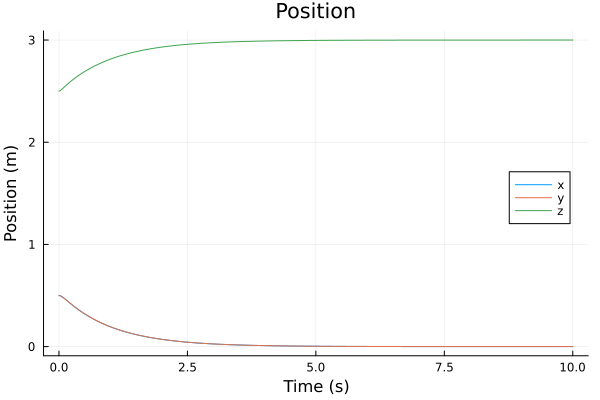

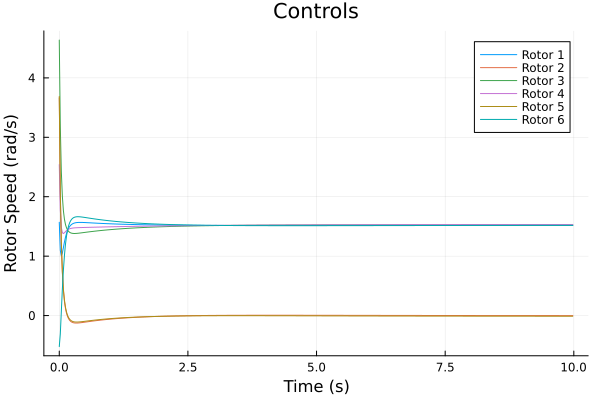

┌ Info: Listening on: 127.0.0.1:8758, thread id: 1
└ @ HTTP.Servers /Users/ashleykline/.julia/packages/HTTP/vnQzp/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8758
└ @ MeshCat /Users/ashleykline/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("drone" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8758, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8758), "127.0.0.1", "8758", nothing, Sockets.TCPServer(RawFD(206) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00000001935d5dd0, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

In [21]:
# ### plotting
# Xm = hcat(X...)
# plot(t_vec, Xm[1:3,:]')
# Xbarm = hcat(X_ref...)
# plot!(t_vec,Xbarm[1:3,:]',ls=:dash)
# #display(plot!(t_vec,))

Xm = mat_from_vec(X)
Um = mat_from_vec(U)

display(plot(t_vec,Xm[1:3,:]',title = "Position",
                xlabel = "Time (s)", ylabel = "Position (m)",
                label = ["x" "y" "z"], legend=:right))

display(plot(t_vec[1:end-1],Um',title = "Controls",
            xlabel = "Time (s)", ylabel= "Rotor Speed (rad/s)",label = ["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))  

display(animate_hexrotor(X, dt))

In [18]:
# what is the time it takes to get to 90% of steady state state

# find index where state= [0.05; 0.05; 2.95; 0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0;0.0]

index= 1
for i= 1:N
    if X[i][1]<= 0.05 && X[i][2] <= 0.05 && X[i][3] >2.95
        return index
    else
        index= index+1  
    end
end
println(index*dt)

2.38
